# EIP-4844 Fee Market Analysis: Data Analysis

In [1]:
import secrets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend
from random import randint, uniform

sns.set(style="whitegrid")

In [2]:
demand_input = pd.read_csv('data/data.csv.gz', index_col=False)
arb_demand_input = demand_input[demand_input['data_tag'] == 'arb_data']
op_demand_input = demand_input[demand_input['data_tag'] == 'op_data']

In [3]:
arb_blocks = arb_demand_input[['block_number']].drop_duplicates().sort_values('block_number')
op_blocks = op_demand_input[['block_number']].drop_duplicates().sort_values('block_number')

In [4]:
arb_blocks['diff'] = arb_blocks['block_number'] - arb_blocks.shift()['block_number'] 
op_blocks['diff'] = op_blocks['block_number'] - op_blocks.shift()['block_number'] 

Text(0.5, 1.0, 'Blocks between batches')

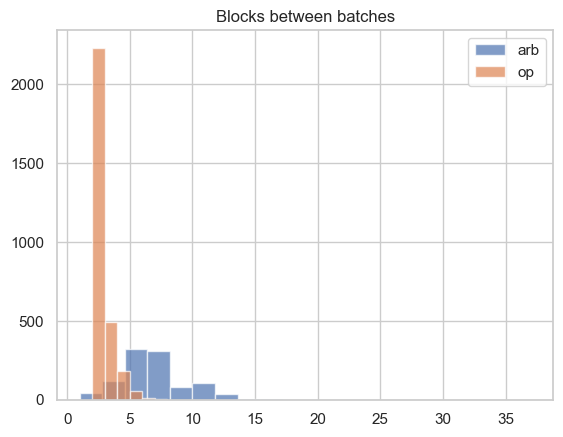

In [5]:
ax=arb_blocks[['diff']].hist(label='arb', bins=20, alpha=0.7)
op_blocks[['diff']].hist(ax=ax, bins=10, label='op', alpha=0.7)
plt.legend()
plt.title('Blocks between batches')

In [6]:
## Etherscan TX Charts

In [7]:
op_txs = pd.read_csv('data/op-TxGrowth.csv.gz', index_col=False)
arb_txs = pd.read_csv('data/arb-TxGrowth.csv.gz', index_col=False)

In [8]:
op_txs.head()

,Date(UTC),UnixTimeStamp,Value
0,1/14/2021,1610582400,440
1,1/15/2021,1610668800,0
2,1/16/2021,1610755200,0
3,1/17/2021,1610841600,0
4,1/18/2021,1610928000,0


In [9]:
arb_txs.head()

,Date(UTC),UnixTimeStamp,Value
0,5/29/2021,1622246400,48
1,5/30/2021,1622332800,25
2,5/31/2021,1622419200,73
3,6/1/2021,1622505600,44
4,6/2/2021,1622592000,171


In [10]:
both_txs = op_txs.merge(arb_txs, how='outer', on='UnixTimeStamp')
both_txs.head()

,Date(UTC)_x,UnixTimeStamp,Value_x,Date(UTC)_y,Value_y
0,1/14/2021,1610582400,440,NaN,NaN
1,1/15/2021,1610668800,0,NaN,NaN
2,1/16/2021,1610755200,0,NaN,NaN
3,1/17/2021,1610841600,0,NaN,NaN
4,1/18/2021,1610928000,0,NaN,NaN


In [11]:
both_txs = both_txs.fillna(0)
both_txs['total_value'] = both_txs['Value_x'] + both_txs['Value_y']

In [12]:
both_txs.head()

,Date(UTC)_x,UnixTimeStamp,Value_x,Date(UTC)_y,Value_y,total_value
0,1/14/2021,1610582400,440,0,0.0,440.0
1,1/15/2021,1610668800,0,0,0.0,0.0
2,1/16/2021,1610755200,0,0,0.0,0.0
3,1/17/2021,1610841600,0,0,0.0,0.0
4,1/18/2021,1610928000,0,0,0.0,0.0


In [13]:
both_txs.sort_values('total_value', ascending=False).head()

,Date(UTC)_x,UnixTimeStamp,Value_x,Date(UTC)_y,Value_y,total_value
798,3/23/2023,1679529600,228684,3/23/2023,2733872.0,2962556.0
823,4/17/2023,1681689600,387682,4/17/2023,1939877.0,2327559.0
799,3/24/2023,1679616000,234153,3/24/2023,1821298.0,2055451.0
825,4/19/2023,1681862400,351500,4/19/2023,1575499.0,1926999.0
805,3/30/2023,1680134400,287973,3/30/2023,1485928.0,1773901.0


In [14]:
# highest txs from inner join might have more contention
both_txs_inner = op_txs.merge(arb_txs, how='inner', on='UnixTimeStamp')

In [15]:
both_txs_inner.head()

,Date(UTC)_x,UnixTimeStamp,Value_x,Date(UTC)_y,Value_y
0,5/29/2021,1622246400,0,5/29/2021,48
1,5/30/2021,1622332800,0,5/30/2021,25
2,5/31/2021,1622419200,0,5/31/2021,73
3,6/1/2021,1622505600,0,6/1/2021,44
4,6/2/2021,1622592000,0,6/2/2021,171


In [16]:
both_txs_inner['total_value'] = both_txs_inner['Value_x'] + both_txs_inner['Value_y']
both_txs_inner.sort_values('total_value', ascending=False).head()

,Date(UTC)_x,UnixTimeStamp,Value_x,Date(UTC)_y,Value_y,total_value
663,3/23/2023,1679529600,228684,3/23/2023,2733872,2962556
688,4/17/2023,1681689600,387682,4/17/2023,1939877,2327559
664,3/24/2023,1679616000,234153,3/24/2023,1821298,2055451
690,4/19/2023,1681862400,351500,4/19/2023,1575499,1926999
670,3/30/2023,1680134400,287973,3/30/2023,1485928,1773901
